---
title: "Module 05: Lab 02"
subtitle: "Regression Modeling on Employment Data"
author:
  - name: Yinuo Wang
    affiliations:
      - id: BU
        name: Boston University
        city: Boston
        state: MA
number-sections: true
date: "2025-04-08"
format:
  html:
    theme: cerulean
    toc: true
    toc-depth: 2
date-modified: today
date-format: long
execute: 
  echo: false
  eval: false
  freeze: auto
---


# Load the Dataset

In [2]:
#| eval: true
#| echo: true
from pyspark.sql import SparkSession
import pandas as pd
import plotly.express as px
import plotly.io as pio
pio.renderers.default = "notebook"

# Initialize Spark Session
spark = SparkSession.builder.appName("LightcastData").getOrCreate()

# Load Data
df = spark.read.option("header", "true").option("inferSchema", "true").option("multiLine","true").option("escape", "\"").csv("./lightcast_job_postings.csv")

# Show Schema and Sample Data
df.printSchema() # comment this line when rendering the submission
df.show(5)

root
 |-- ID: string (nullable = true)
 |-- LAST_UPDATED_DATE: string (nullable = true)
 |-- LAST_UPDATED_TIMESTAMP: timestamp (nullable = true)
 |-- DUPLICATES: integer (nullable = true)
 |-- POSTED: string (nullable = true)
 |-- EXPIRED: string (nullable = true)
 |-- DURATION: integer (nullable = true)
 |-- SOURCE_TYPES: string (nullable = true)
 |-- SOURCES: string (nullable = true)
 |-- URL: string (nullable = true)
 |-- ACTIVE_URLS: string (nullable = true)
 |-- ACTIVE_SOURCES_INFO: string (nullable = true)
 |-- TITLE_RAW: string (nullable = true)
 |-- BODY: string (nullable = true)
 |-- MODELED_EXPIRED: string (nullable = true)
 |-- MODELED_DURATION: integer (nullable = true)
 |-- COMPANY: integer (nullable = true)
 |-- COMPANY_NAME: string (nullable = true)
 |-- COMPANY_RAW: string (nullable = true)
 |-- COMPANY_IS_STAFFING: boolean (nullable = true)
 |-- EDUCATION_LEVELS: string (nullable = true)
 |-- EDUCATION_LEVELS_NAME: string (nullable = true)
 |-- MIN_EDULEVELS: integer (

# Feature Engineering

In [3]:
from pyspark.sql.functions import col
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler
from pyspark.ml import Pipeline

# Drop rows with missing values in SALARY and selected features
df = df.dropna(subset=[
    "SALARY", "MIN_YEARS_EXPERIENCE", "SALARY_FROM", "EMPLOYMENT_TYPE_NAME"
])

# Categorical column
categorical_cols = ["EMPLOYMENT_TYPE_NAME"]

# Indexing and Encoding categorical feature
indexers = [StringIndexer(inputCol=col, outputCol=f"{col}_idx", handleInvalid='skip') for col in categorical_cols]
encoders = [OneHotEncoder(inputCol=f"{col}_idx", outputCol=f"{col}_vec") for col in categorical_cols]

# Assemble features into one vector
assembler = VectorAssembler(
    inputCols=["MIN_YEARS_EXPERIENCE", "SALARY_FROM"] + [f"{col}_vec" for col in categorical_cols],
    outputCol="features"
)

# Build pipeline
pipeline = Pipeline(stages=indexers + encoders + [assembler])

# Apply pipeline transformation
data = pipeline.fit(df).transform(df)

# Show result
data.select("features", "SALARY").show(5, truncate=False)


+----------------------+------+
|features              |SALARY|
+----------------------+------+
|[2.0,79500.0,1.0,0.0] |92962 |
|[10.0,91559.0,1.0,0.0]|107645|
|[6.0,144600.0,1.0,0.0]|192800|
|[12.0,63200.0,1.0,0.0]|125900|
|[6.0,120000.0,1.0,0.0]|170000|
+----------------------+------+
only showing top 5 rows



# Train/Test Split

In [4]:
#| eval: true
#| echo: false
train_data, test_data = data.randomSplit([0.8, 0.2], seed=688)
print((train_data.count(), len(train_data.columns)))
print((test_data.count(), len(test_data.columns)))

(18992, 134)


(4705, 134)


I choose to set the seed equal to 688 since this class is called AD 688.

# Linear Regression

In [11]:
#| eval: true
#| echo: true
from pyspark.ml.regression import LinearRegression
from pyspark.sql.types import StructType, StructField, StringType, DoubleType
from pyspark.ml.evaluation import RegressionEvaluator

# 1. Initialize Linear Regression with proper solver
lr = LinearRegression(featuresCol="features", 
                    labelCol="SALARY",
                    solver="normal",  # Required for statistics
                    regParam=0.1)    # Small regularization

# 2. Fit the model
lr_model = lr.fit(train_data)
summary = lr_model.summary

# 3. Define schema explicitly for the results DataFrame
schema = StructType([
    StructField("Feature", StringType()),
    StructField("Coefficient", DoubleType()),
    StructField("Std_Error", DoubleType()),
    StructField("t_value", DoubleType()),
    StructField("p_value", DoubleType()),
    StructField("Significance", StringType())
])

# 4. Prepare results data with proper typing
results_data = []
results_data.append((
    "Intercept",
    float(lr_model.intercept),
    float(summary.coefficientStandardErrors[-1]),
    float(summary.tValues[-1]),
    float(summary.pValues[-1]),
    "***" if summary.pValues[-1] < 0.001 else "**" if summary.pValues[-1] < 0.01 else "*" if summary.pValues[-1] < 0.05 else ""
))

feature_names = ["MIN_YEARS_EXPERIENCE", "SALARY_FROM"] + \
               [f"EMPLOYMENT_TYPE_{i}" for i in range(len(lr_model.coefficients)-2)]

for i in range(len(lr_model.coefficients)):
    results_data.append((
        feature_names[i],
        float(lr_model.coefficients[i]),
        float(summary.coefficientStandardErrors[i]),
        float(summary.tValues[i]),
        float(summary.pValues[i]),
        "***" if summary.pValues[i] < 0.001 else "**" if summary.pValues[i] < 0.01 else "*" if summary.pValues[i] < 0.05 else ""
    ))

# 5. Create DataFrame with explicit schema
results_df = spark.createDataFrame(results_data, schema=schema)

# 6. Model evaluation
metrics = {
    "R-squared": summary.r2,
    "Adjusted R-squared": summary.r2adj,
    "RMSE": summary.rootMeanSquaredError,
    "MAE": summary.meanAbsoluteError
}

# 7. Test set evaluation
predictions = lr_model.transform(test_data)
evaluator = RegressionEvaluator(labelCol="SALARY", predictionCol="prediction")
test_metrics = {
    "Test R-squared": evaluator.setMetricName("r2").evaluate(predictions),
    "Test RMSE": evaluator.setMetricName("rmse").evaluate(predictions)
}

# 8. Print results
print("="*80)
print("LINEAR REGRESSION RESULTS")
print("="*80)
print("\nCOEFFICIENTS:")
results_df.show(truncate=False)

print("\nTRAINING SET METRICS:")
for name, value in metrics.items():
    print(f"{name}: {value:.4f}")

print("\nTEST SET METRICS:")
for name, value in test_metrics.items():
    print(f"{name}: {value:.4f}")

print("\nSIGNIFICANCE CODES:")
print("*** p < 0.001, ** p < 0.01, * p < 0.05")

print("\nINTERPRETATION:")
print("1. Coefficients show the expected change in salary per unit change in each feature")
print("2. Significant features (marked with *) have statistically meaningful impact")
print("3. R-squared indicates the proportion of variance explained by the model")
print("4. Compare training and test metrics to check for overfitting")


LINEAR REGRESSION RESULTS

COEFFICIENTS:


+--------------------+-------------------+---------------------+-------------------+--------------------+------------+
|Feature             |Coefficient        |Std_Error            |t_value            |p_value             |Significance|
+--------------------+-------------------+---------------------+-------------------+--------------------+------------+
|Intercept           |23029.47348798506  |978.6458950018632    |23.53197781301807  |0.0                 |***         |
|MIN_YEARS_EXPERIENCE|2706.7596041966103 |40.688044884183675   |66.52469077590864  |0.0                 |***         |
|SALARY_FROM         |0.9534859369215344 |0.0036521086337042447|261.07819688661255 |0.0                 |***         |
|EMPLOYMENT_TYPE_0   |-10249.958939611826|947.3523566368509    |-10.819584569356751|0.0                 |***         |
|EMPLOYMENT_TYPE_1   |-6238.748642385512 |1209.2080338559833   |-5.159367509733686 |2.502786442537541E-7|***         |
+--------------------+-------------------+------

## Generalized Linear Regression Summary

In [15]:
#| eval: true
#| echo: true
import pandas as pd

# Get model statistics
coefficients = lr_model.coefficients
std_errors = summary.coefficientStandardErrors
t_values = summary.tValues 
p_values = summary.pValues

# Create two versions of the coefficient table:
# 1. For display (formatted strings)
# 2. For calculations (raw numbers)

# Calculation version (raw numbers)
calc_table = pd.DataFrame({
    "Feature": ["Intercept"] + feature_names,
    "Estimate": [lr_model.intercept] + list(coefficients),
    "Std_Error": std_errors,
    "t_stat": t_values,
    "P_Value": p_values
})

# Display version (formatted strings)
display_table = pd.DataFrame({
    "Feature": calc_table["Feature"],
    "Estimate": calc_table["Estimate"].apply(lambda x: f"{x:.4f}"),
    "Std Error": calc_table["Std_Error"].apply(lambda x: f"{x:.4f}"),
    "t-stat": calc_table["t_stat"].apply(lambda x: f"{x:.2f}"),
    "P-Value": calc_table["P_Value"].apply(lambda x: f"{x:.4f}"),
    "Sig": calc_table["P_Value"].apply(
        lambda p: '***' if p < 0.001 else '**' if p < 0.01 else '*' if p < 0.05 else ''
    )
})

# Display the formatted table
print("="*80)
print("GENERALIZED LINEAR REGRESSION SUMMARY")
print("="*80)
print(display_table.to_string(index=False))

# Interpretation using the calculation table
print("\n=== STATISTICAL INTERPRETATION ===")
print("1. Estimate: Expected salary change per unit change in feature")
print("   - For categorical: Difference from reference category")
print("2. Std Error: Measure of estimate precision (smaller = better)")
print("3. t-stat: Estimate divided by Std Error (|t| > 2 suggests significance)")
print("4. P-Value: Probability of observing this result by chance alone")
print("   - *** p < 0.001 (Highly significant)")
print("   - ** p < 0.01 (Very significant)")
print("   - * p < 0.05 (Significant)")

print("\n=== BUSINESS INSIGHTS ===")
print(f"- Most significant feature: {calc_table.loc[calc_table['t_stat'].abs().idxmax(), 'Feature']}")
print(f"- Strongest positive influence: {calc_table.loc[calc_table['Estimate'].idxmax(), 'Feature']}")
print(f"- Strongest negative influence: {calc_table.loc[calc_table['Estimate'].idxmin(), 'Feature']}")
print(f"- {sum(calc_table['P_Value'] < 0.05)}/{len(calc_table)} features statistically significant")

GENERALIZED LINEAR REGRESSION SUMMARY
             Feature    Estimate Std Error t-stat P-Value Sig
           Intercept  23029.4735   40.6880  66.52  0.0000 ***
MIN_YEARS_EXPERIENCE   2706.7596    0.0037 261.08  0.0000 ***
         SALARY_FROM      0.9535  947.3524 -10.82  0.0000 ***
   EMPLOYMENT_TYPE_0 -10249.9589 1209.2080  -5.16  0.0000 ***
   EMPLOYMENT_TYPE_1  -6238.7486  978.6459  23.53  0.0000 ***

=== STATISTICAL INTERPRETATION ===
1. Estimate: Expected salary change per unit change in feature
   - For categorical: Difference from reference category
2. Std Error: Measure of estimate precision (smaller = better)
3. t-stat: Estimate divided by Std Error (|t| > 2 suggests significance)
4. P-Value: Probability of observing this result by chance alone
   - *** p < 0.001 (Highly significant)
   - ** p < 0.01 (Very significant)
   - * p < 0.05 (Significant)

=== BUSINESS INSIGHTS ===
- Most significant feature: MIN_YEARS_EXPERIENCE
- Strongest positive influence: Intercept
- Stronge

# Diagnostic Plot

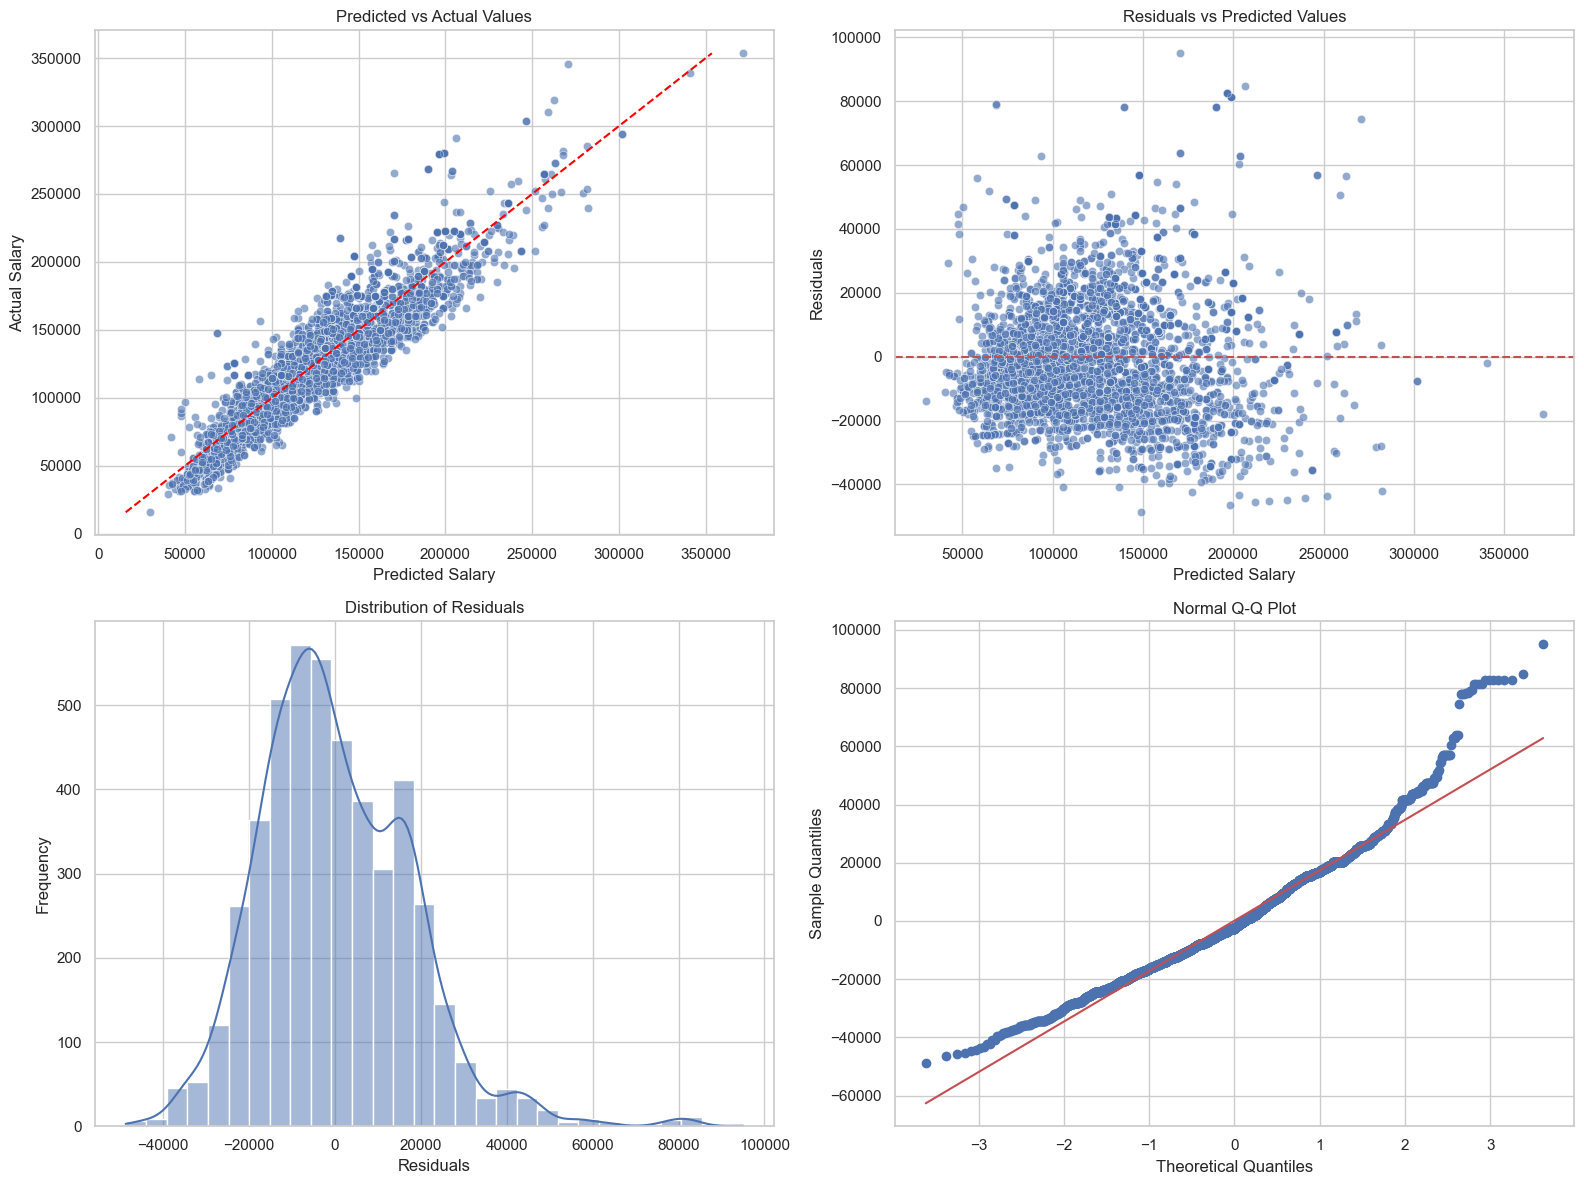

In [16]:
#| eval: true
#| echo: true
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import numpy as np

# Convert predictions to pandas DataFrame
df_pred = predictions.select("SALARY", "prediction").toPandas()

# Compute residuals and other diagnostic metrics
df_pred["residuals"] = df_pred["SALARY"] - df_pred["prediction"]
df_pred["fitted"] = df_pred["prediction"]

# Standardized residuals
res_mean = df_pred["residuals"].mean()
res_std = df_pred["residuals"].std()
df_pred["std_residuals"] = (df_pred["residuals"] - res_mean) / res_std

# Square root of absolute standardized residuals (for Scale-Location plot)
df_pred["sqrt_std_resid"] = np.sqrt(np.abs(df_pred["std_residuals"]))

# Create diagnostic plots
plt.figure(figsize=(16, 12))
sns.set_theme(style="whitegrid")

# Plot 1: Predicted vs Actual
plt.subplot(2, 2, 1)
sns.scatterplot(x="fitted", y="SALARY", data=df_pred, alpha=0.6)
plt.plot([df_pred["SALARY"].min(), df_pred["SALARY"].max()], 
         [df_pred["SALARY"].min(), df_pred["SALARY"].max()], 
         color='red', linestyle='--')
plt.title('Predicted vs Actual Values')
plt.xlabel('Predicted Salary')
plt.ylabel('Actual Salary')

# Plot 2: Residuals vs Predicted
plt.subplot(2, 2, 2)
sns.scatterplot(x="fitted", y="residuals", data=df_pred, alpha=0.6)
plt.axhline(y=0, color='r', linestyle='--')
plt.title('Residuals vs Predicted Values')
plt.xlabel('Predicted Salary')
plt.ylabel('Residuals')

# Plot 3: Histogram of Residuals
plt.subplot(2, 2, 3)
sns.histplot(df_pred["residuals"], kde=True, bins=30)
plt.title('Distribution of Residuals')
plt.xlabel('Residuals')
plt.ylabel('Frequency')

# Plot 4: Q-Q Plot of Residuals
plt.subplot(2, 2, 4)
stats.probplot(df_pred["residuals"], dist="norm", plot=plt)
plt.title('Normal Q-Q Plot')
plt.xlabel('Theoretical Quantiles')
plt.ylabel('Sample Quantiles')

plt.tight_layout()
plt.savefig("diagnostic_plots.png", dpi=300, bbox_inches='tight')
plt.show()

# Evaluation

In [18]:
#| eval: true
#| echo: true
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.sql.functions import col, pow, sqrt, avg, log
import numpy as np

# Get predictions
pred_glr = lr_model.transform(test_data)

# Initialize evaluator
evaluator = RegressionEvaluator(labelCol="SALARY", predictionCol="prediction")

# Calculate metrics
r2 = evaluator.setMetricName("r2").evaluate(pred_glr)
rmse = evaluator.setMetricName("rmse").evaluate(pred_glr)
mae = evaluator.setMetricName("mae").evaluate(pred_glr)

# Calculate RSS (Residual Sum of Squares) manually
residuals_df = pred_glr.withColumn("squared_error", pow(col("SALARY") - col("prediction"), 2))
rss = residuals_df.select(avg("squared_error")).collect()[0][0] * train_data.count()

# Calculate information criteria manually
n = train_data.count()  # Number of observations
k = len(lr_model.coefficients) + 1  # Number of parameters (features + intercept)

# AIC calculation
aic = n * np.log(rss/n) + 2 * k

# BIC calculation
bic = n * np.log(rss/n) + k * np.log(n)

# Print all metrics
print("="*50)
print("MODEL EVALUATION METRICS")
print("="*50)
print(f"R-squared (R²): {r2:.4f}")
print(f"Adjusted R-squared: {summary.r2adj:.4f}")
print(f"AIC: {aic:.2f}")
print(f"BIC: {bic:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")

# Interpretation
print("\n=== INTERPRETATION ===")
print(f"1. R² of {r2:.2f} indicates the model explains {r2*100:.0f}% of salary variance")
print(f"2. RMSE of {rmse:.2f} means average prediction error is ${rmse:,.0f}")
print(f"3. AIC/BIC values can be used to compare with alternative models (lower is better)")
print("4. MAE provides a robust measure of average error magnitude")

# Create metrics DataFrame for visualization
metrics_data = [
    ("R-squared", float(r2)),
    ("Adjusted R-squared", float(summary.r2adj)),
    ("RMSE", float(rmse)),
    ("MAE", float(mae)),
    ("AIC", float(aic)),
    ("BIC", float(bic))
]

metrics_df = spark.createDataFrame(metrics_data, ["Metric", "Value"])
metrics_df.show()

MODEL EVALUATION METRICS
R-squared (R²): 0.8401
Adjusted R-squared: 0.8388
AIC: 371268.27
BIC: 371307.53
RMSE: 17572.14
MAE: 13778.77

=== INTERPRETATION ===
1. R² of 0.84 indicates the model explains 84% of salary variance
2. RMSE of 17572.14 means average prediction error is $17,572
3. AIC/BIC values can be used to compare with alternative models (lower is better)
4. MAE provides a robust measure of average error magnitude
+------------------+------------------+
|            Metric|             Value|
+------------------+------------------+
|         R-squared|0.8400830514521992|
|Adjusted R-squared|0.8388496273591057|
|              RMSE|17572.139070297202|
|               MAE| 13778.77268681809|
|               AIC|371268.27181760594|
|               BIC| 371307.5306831902|
+------------------+------------------+



## Model Evaluation Plot

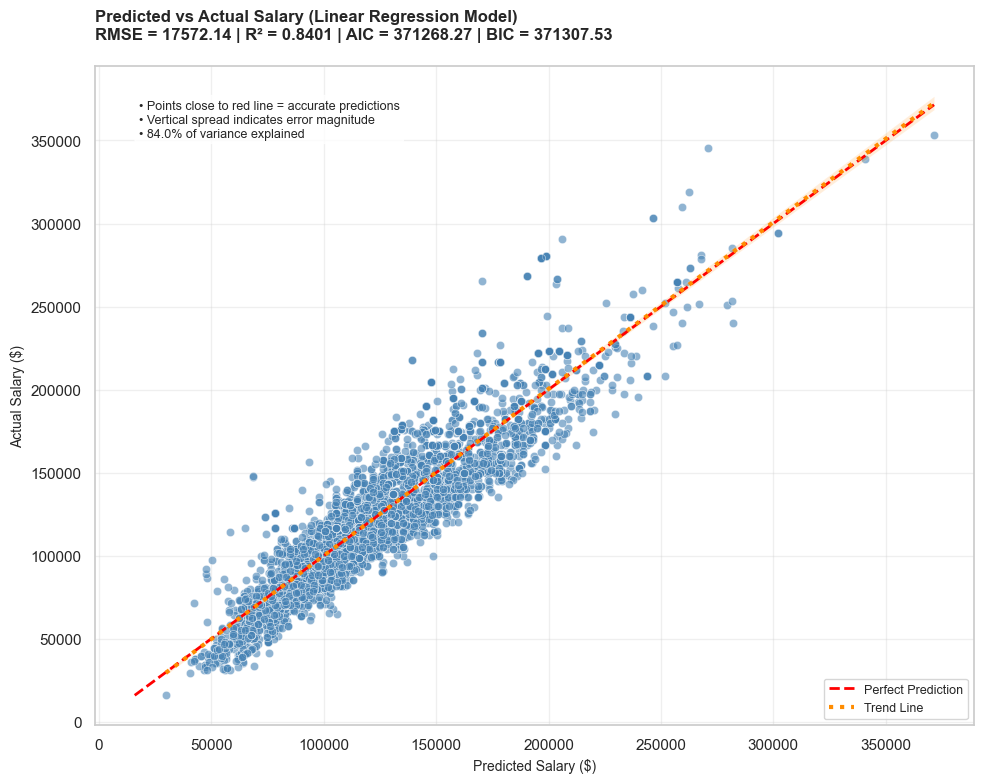

In [19]:
#| eval: true
#| echo: true
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Convert predictions to pandas DataFrame
pandas_df = pred_glr.select("SALARY", "prediction").toPandas()

# Create the plot
plt.figure(figsize=(10, 8))
sns.set_style("whitegrid")

# Scatter plot of predictions vs actual
ax = sns.scatterplot(x="prediction", y="SALARY", data=pandas_df, 
                    alpha=0.6, color="steelblue", edgecolor="white")

# Add ideal fit line (y=x)
max_val = max(pandas_df["SALARY"].max(), pandas_df["prediction"].max())
min_val = min(pandas_df["SALARY"].min(), pandas_df["prediction"].min())
plt.plot([min_val, max_val], [min_val, max_val], 
         color="red", linestyle="--", linewidth=2, label="Perfect Prediction")

# Add regression line
sns.regplot(x="prediction", y="SALARY", data=pandas_df, 
           scatter=False, color="darkorange", line_kws={"linestyle":":", "linewidth":3}, 
           label="Trend Line")

# Customize plot
plt.title(f"Predicted vs Actual Salary (Linear Regression Model)\n"
          f"RMSE = {rmse:.2f} | R² = {r2:.4f} | AIC = {aic:.2f} | BIC = {bic:.2f}", 
          loc="left", pad=20, fontsize=12, fontweight="bold")
plt.xlabel("Predicted Salary ($)", fontsize=10)
plt.ylabel("Actual Salary ($)", fontsize=10)
plt.legend(fontsize=9)
plt.grid(True, alpha=0.3)

# Add text box with insights
textstr = '\n'.join((
    f'• Points close to red line = accurate predictions',
    f'• Vertical spread indicates error magnitude',
    f'• {r2*100:.1f}% of variance explained'))
plt.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=9,
        verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

plt.tight_layout()

# Save figure
plt.savefig("predicted_vs_actual.png", dpi=300, bbox_inches='tight')
plt.show()